In [1]:
import pandas as pd 
import numpy as np 
import psycopg2
import os 
from dotenv import load_dotenv
import seaborn as sns 
from datetime import datetime, timedelta

In [2]:
import matplotlib.pyplot as plt

In [3]:
def create_connection():
    load_dotenv()
    DATABASE = os.getenv("DATABASE")
    HOST = os.getenv("HOST")
    USER = os.getenv("USER")
    PASSWORD = os.getenv("PASSWORD")
    PORT = os.getenv("PORT")
    connection = psycopg2.connect(
        host=HOST, database=DATABASE, user=USER, password=PASSWORD
    )
    return connection

In [4]:
USER_ID = 19

## Extraction des données liés aux sport_rows

In [5]:
connection = create_connection()
cursor = connection.cursor()
sql =   """
            SELECT * FROM sport_rows
            WHERE user_id = %s
        """
cursor.execute(sql, (USER_ID,))
data = cursor.fetchall()


In [6]:
df_sport_row = pd.DataFrame(data, columns=["date_seance","sport","exercice","duree","commentaire","id","user_id"])
df_sport_row.head()

,date_seance,sport,exercice,duree,commentaire,id,user_id
0,2024-02-24,Cardio,Vélo Elliptique,30.0,None,26,19
1,2024-02-24,Cardio,Cross Trainning,30.0,None,27,19
2,2024-02-24,Cardio,Tennis,60.0,None,28,19
3,2024-02-03,Cardio,Cross Trainning,NaN,20 pompes \n20 ballons mur en équilibres \n12 ...,95,19
4,2024-04-03,Cardio,Tennis,60.0,None,143,19



## Extraction des données liés aux musculation_rows

In [7]:
connection = create_connection()
cursor = connection.cursor()
sql =   """
            SELECT * FROM musculation_rows
            WHERE user_id = %s
        """
cursor.execute(sql, (USER_ID,))
data = cursor.fetchall()


In [8]:
df_musculation_row = pd.DataFrame(data, columns=["date_seance","seance","exercice","poid","nombre_repetition","commentaires","user_id"])
df_musculation_row.head()

,date_seance,seance,exercice,poid,nombre_repetition,commentaires,user_id
0,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19
1,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19
2,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19
3,2024-02-19,Pectoraux,Développé Couché,50.0,10.0,None,19
4,2024-02-19,Pectoraux,Développé Couché,50.0,9.0,None,19


In [9]:
df_musculation_row.shape

(1232, 7)

In [10]:
df_sport_row.shape

(38, 7)

In [11]:
connection = create_connection()
cursor = connection.cursor()
sql =   """
            SELECT * FROM cross_trainning_rows
            WHERE user_id = %s
        """
cursor.execute(sql, (USER_ID,))
data = cursor.fetchall()


In [12]:
df__cross_trainning_rows = pd.DataFrame(data, columns=["id","user_id","cross_trainning_serie_id","number","nombre_repetition","commentaires","user_id"])
df__cross_trainning_rows.head()

,id,user_id,cross_trainning_serie_id,number,nombre_repetition,commentaires,user_id


In [13]:
df_musculation_row.columns

Index(['date_seance', 'seance', 'exercice', 'poid', 'nombre_repetition',
       'commentaires', 'user_id'],
      dtype='object')

In [14]:
df_sport_row.columns

Index(['date_seance', 'sport', 'exercice', 'duree', 'commentaire', 'id',
       'user_id'],
      dtype='object')

In [15]:
df_all_sport = pd.concat([df_musculation_row,df_sport_row])

In [16]:
df_all_sport

,date_seance,seance,exercice,poid,nombre_repetition,commentaires,user_id,sport,duree,commentaire,id
0,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
1,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
2,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
3,2024-02-19,Pectoraux,Développé Couché,50.0,10.0,None,19,NaN,NaN,NaN,NaN
4,2024-02-19,Pectoraux,Développé Couché,50.0,9.0,None,19,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
33,2024-06-29,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,992.0
34,2024-06-30,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,993.0
35,2024-07-01,NaN,Stepper,NaN,NaN,NaN,19,Cardio,NaN,None,1012.0
36,2024-07-02,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,1026.0


In [17]:
df_all_sport.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1270 entries, 0 to 37
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_seance        1269 non-null   object 
 1   seance             1227 non-null   object 
 2   exercice           1269 non-null   object 
 3   poid               1158 non-null   float64
 4   nombre_repetition  1228 non-null   float64
 5   commentaires       29 non-null     object 
 6   user_id            1270 non-null   int64  
 7   sport              38 non-null     object 
 8   duree              33 non-null     float64
 9   commentaire        5 non-null      object 
 10  id                 38 non-null     float64
dtypes: float64(4), int64(1), object(6)
memory usage: 119.1+ KB


In [18]:
df_all_sport["date_seance"] = pd.to_datetime(df_all_sport["date_seance"])



In [19]:
def create_empty_timeserie(time_analyse:str)->pd.Series:
    today_date = datetime.today().date()
    if time_analyse == "week":
        end_date = today_date - timedelta(weeks=1)
    elif time_analyse == "month":
        end_date = today_date - timedelta(days=30)
    elif time_analyse == "year":
        end_date = today_date - timedelta(days=365)
    else:
        raise ValueError("time_analyse must be 'week', 'month', or 'year'")
    
    return pd.date_range(start=end_date, end=today_date)

In [20]:
def filter_by_time_period(df_all_sport:pd.DataFrame, time_analyse:str) :
    try : 
        df_all_sport["date_seance"] = pd.to_datetime(df_all_sport["date_seance"])
    except: 
        print("donnée date_seance déjà transformé")

    date_series = create_empty_timeserie(time_analyse)
    df_time_period = df_all_sport[
    (df_all_sport["date_seance"] > date_series.min()) & 
    (df_all_sport["date_seance"] < date_series.max())
]
    return df_time_period

In [21]:
df = filter_by_time_period(df_all_sport, "month")
df.head()

,date_seance,seance,exercice,poid,nombre_repetition,commentaires,user_id,sport,duree,commentaire,id
158,2024-08-03,Bras,Triceps à la Poulie,36.0,12.0,None,19,NaN,NaN,NaN,NaN
159,2024-08-03,Bras,Triceps à la Poulie,41.0,12.0,None,19,NaN,NaN,NaN,NaN
160,2024-08-03,Bras,Triceps à la Poulie,25.3,12.0,None,19,NaN,NaN,NaN,NaN
161,2024-08-03,Bras,Triceps à la Poulie,25.3,11.0,None,19,NaN,NaN,NaN,NaN
162,2024-08-03,Bras,Triceps à la Poulie,25.3,11.0,None,19,NaN,NaN,NaN,NaN


In [22]:

timeseries = create_empty_timeserie(time_analyse="month")
df_timeseries = pd.DataFrame(timeseries, columns=['date'])
df_timeseries['did_sport_this_day'] = df_timeseries['date'].apply(lambda x: 1 if x in df['date_seance'].values else 0)
print(df_timeseries.head())

        date  did_sport_this_day
0 2024-07-31                   0
1 2024-08-01                   0
2 2024-08-02                   0
3 2024-08-03                   1
4 2024-08-04                   1


In [23]:
df_timeseries.head()

,date,did_sport_this_day
0,2024-07-31,0
1,2024-08-01,0
2,2024-08-02,0
3,2024-08-03,1
4,2024-08-04,1


In [36]:
date_series.max()


Timestamp('2024-08-30 00:00:00')

In [35]:
date_series.min()


Timestamp('2024-07-31 00:00:00')

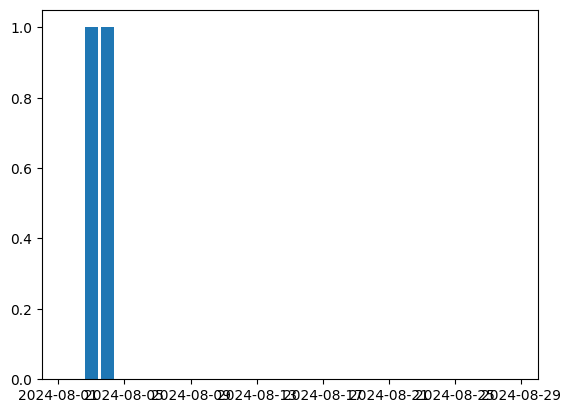

In [37]:
date_series = create_empty_timeserie("month")
plt.bar(df_timeseries["date"], df_timeseries["did_sport_this_day"])
plt.xlim(date_series.min(), date_series.max())
plt.show()

In [25]:
def plot_seance_by_time_period(df:pd.DataFrame,time_analyse:str)-> None:
    date_series = create_empty_timeserie(time_analyse)
    
   
    

In [26]:
df = filter_by_time_period(df_all_sport, "year")

In [27]:
df

,date_seance,seance,exercice,poid,nombre_repetition,commentaires,user_id,sport,duree,commentaire,id
0,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
1,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
2,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
3,2024-02-19,Pectoraux,Développé Couché,50.0,10.0,None,19,NaN,NaN,NaN,NaN
4,2024-02-19,Pectoraux,Développé Couché,50.0,9.0,None,19,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
33,2024-06-29,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,992.0
34,2024-06-30,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,993.0
35,2024-07-01,NaN,Stepper,NaN,NaN,NaN,19,Cardio,NaN,None,1012.0
36,2024-07-02,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,1026.0


In [28]:
def get_numerical_value(df_time_period:pd.DataFrame):
    number_of_day =df_time_period["date_seance"].ncount()
    number_of_exercice = df_time_period.groupby("date_seance")
    return number_of_day



In [29]:
number_of_exercice = df.groupby("exercice").agg("count")
number_of_diferents_exercices = df["exercice"].nunique()


In [30]:
df["exercice"].unique()

array(['Développé Couché', 'Ecartés Poulie', 'Lat Pull',
       'Seated Row Prise Verticale', 'Biceps Curls', 'Squat',
       'Hip Thrust', 'Mollets sur Leg Press', 'Leg Press',
       'Hip Adduction', 'Prone leg Curl', 'Triceps Pull Downs Poulie',
       'Pec Fly', 'Biceps Curl Assis', 'Rear Delt', 'Hip Abduction',
       'Leg Extension', 'Développé Incliné', 'Shoulder press',
       'Dip Assist', 'Développé Incliné Haltères', 'Seated Row',
       'Arm Curl', 'Élévations Latérales Haltères', 'Triceps à la Poulie',
       'Triceps à la Poulie Inversée', 'Biceps Curl Allongé',
       'Triceps à la poulie', 'Biceps Curl Poulie', 'Rotary Torso',
       'Abdos Machine', 'Chest Press', 'Machine Abdominaux',
       'Lower Back Bench', 'Back Extension',
       'Diverging Seated Row Prise Verticale',
       'Développé Militaire à la barre',
       'Élévations Latérales à la Poulie', 'Converging Shoulder Press',
       'Traction avec Élastique', 'Élévations Frontales Haltères',
       'Développ

In [31]:
number_of_diferents_exercices

80

In [32]:
poid_portée = df["poid"].sum()


In [33]:
poid_portée

np.float64(42335.8)